In [1]:
'''
Fold 2 of 20210308 (epoch 8) is the model trained with almost all the data
'''
TRAIN_IMG_SRC_FOLDER = "/home/guilherme/Documents/noa/cidia19/data/spgc/views/"
VALIDATION_IMG_SRC_FOLDER = "/home/guilherme/Documents/noa/cidia19/data/spgc/views/"

SUB_FILE = ['axis1', 'axis2']
# SUB_FILE = ['axis1']

EPOCHS = 10
IMG_HEIGHT = 448
IMG_WIDTH = 448
IMG_CHANNELS = 3
NUM_CLASSES = 3
DATA_FOLDER = 'spgc-binario-42img/'
LOG_FOLDER = 'logs/' + DATA_FOLDER
# TRAINING_FOLDER = 'training/20210308/resnet101/fold2/'
# MODEL_FOLDER = 'models/20210308/resnet101/fold2/'
# TRAINING_FOLDER = 'training/20210301/resnet101/fold1/'
# MODEL_FOLDER = 'models/20210301/resnet101/fold1/'
TRAINING_FOLDER = 'training/spgc-binario-42img/densenet201/fold/'
MODEL_FOLDER = 'models/spgc-binario-42img/densenet201/fold/'
COLUMN_TARGET = 'ternario'

STRUCTURE_DATASET_FOLDER = "csv/input/" + DATA_FOLDER
OUTPUT_PREDICTED_FOLDER = "csv/output/" + DATA_FOLDER


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import glob
import os
from datetime import datetime

import tensorflow as tf
import utilities.plot_metrics as pm

In [3]:
def get_file_path(folder, search_filter=''):
    '''
    Get all files (full path) contained in a PATH folder by specified search filter 
    '''
    paths = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            path = os.path.join(root, file)
            if search_filter in path:
                paths.append(path)
    return paths

def get_data_set(fold_number, cur_subfile, data_train, data_test):
    ''' Creates and returns a dataframe with all the full paths (for slice) for train and test images. 
    Save it as log. 
    '''
    dfs = []
    train_images = {"id": [], "label": []}
    validation_images = {"id": [], "label": []}
    
    
    TRAIN_IMG_FOLDERS_SLICE = {}
    for _, row in data_train.iterrows():
        TRAIN_IMG_FOLDERS_SLICE[row['nome']] = row['covid']

    VALIDATION_IMG_FOLDERS_SLICE = {}
    for _, row in data_test.iterrows():
        VALIDATION_IMG_FOLDERS_SLICE[row['nome']] = row['covid']
    
    df_config = [
        (TRAIN_IMG_SRC_FOLDER, TRAIN_IMG_FOLDERS_SLICE, train_images),
        (VALIDATION_IMG_SRC_FOLDER, VALIDATION_IMG_FOLDERS_SLICE, validation_images)
    ]
    for (base, folder, dic) in df_config:
        for img_folder, img_label in folder.items():
            search_folder = "{}/{}".format(base, img_folder)
            imgs_filename = sorted(get_file_path(search_folder, search_filter = cur_subfile))
            dic["id"].extend(imgs_filename)
            dic["label"].extend([img_label] * len(imgs_filename))

        dfs.append(pd.DataFrame(data=dic))
#     print(dfs)
    train_df, validation_df = dfs[0], dfs[1]


    if not os.path.exists("logs/"): 
        os.mkdir("logs/")
    if not os.path.exists(LOG_FOLDER): 
        os.mkdir(LOG_FOLDER)
        
    train_df.to_csv("{}/train{}.csv".format(LOG_FOLDER, fold_number), index=False)
    validation_df.to_csv("{}/test{}.csv".format(LOG_FOLDER, fold_number), index=False)

    print("Train fold with {} images".format(len(train_df)))
    print(train_df.groupby("label").label.count())
    print()
    print("Validation fold with {} images".format(len(validation_df)))
    print(validation_df.groupby("label").label.count())
    print("-" * 30)
    return (train_df, validation_df)

In [4]:
def get_data_generator(dataframe, x_col, y_col, subset=None, shuffle=True, batch_size=32, class_mode="binary"):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.05,
    horizontal_flip=False,
    width_shift_range=0.1,
    height_shift_range=0.1,
    )
    
    data_generator = datagen.flow_from_dataframe(
        dataframe=dataframe,
        x_col=x_col,
        y_col=y_col,
        subset=subset,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        class_mode=class_mode,
        # color_mode="rgb",
        batch_size=batch_size,
        shuffle=shuffle
    )
    return data_generator

In [5]:
def predictions_by_patient(model, patients, legend_file, axis):
    results = []
    if os.path.isfile(legend_file+'.npy'):
        class_indices = np.load(legend_file+'.npy', allow_pickle=True).item()
        class_indices = dict((v,k) for k,v in class_indices.items())
    print(class_indices)
    for p in patients:
        # for axis in SUB_FILE:
        curr_dir = "{}/{}/{}".format(VALIDATION_IMG_SRC_FOLDER, p, axis)
        imgs_filename = sorted(os.listdir(curr_dir))
        test_filenames = imgs_filename[:]
        test_df = pd.DataFrame({
                'filename': test_filenames
            })
        nb_samples = test_df.shape[0]

        test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
        test_generator = test_gen.flow_from_dataframe(
                test_df, 
                curr_dir, 
                x_col='filename',
                y_col=None,
                class_mode=None,
                target_size=(IMG_WIDTH, IMG_HEIGHT),
                batch_size=16,
                shuffle=False
        )

        predict = model.predict(test_generator, steps=np.ceil(nb_samples/16))

        test_df['predicted'] = [np.where(pr == np.max(pr))[0][0] for pr in predict]
        for key in class_indices.keys():
            t = class_indices[key]
            test_df[t] = 0
            test_df.loc[test_df['predicted'] == key, t] = 1
        test_df['patient'] = p
        test_df['axis'] = axis
        results.append(test_df)

    print('Axis: ', test_df['axis'][0])
    df_result = pd.DataFrame()
    for i,test_df in enumerate(results):
        cur_patient = test_df['patient'][0]
        test_df['predicted'] = 0
        test_df['patient'] = 0
        test_df = test_df.groupby(['patient', 'predicted'], as_index = False).sum()
        test_df['predicted'] = test_df.idxmax(axis=1)
        test_df['patient'] = cur_patient
        df_result = df_result.append(test_df)
        
    return df_result
        
    

## Check models!
Load saved model


axis1



Fold 
{0: 'covid', 1: 'normal'}
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated ima

<Figure size 720x216 with 0 Axes>

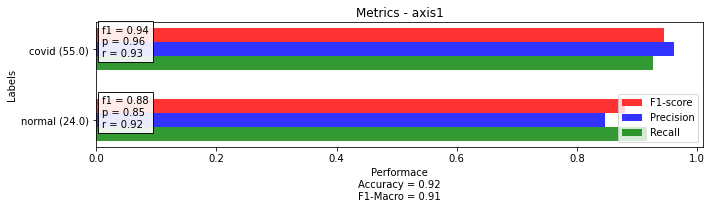

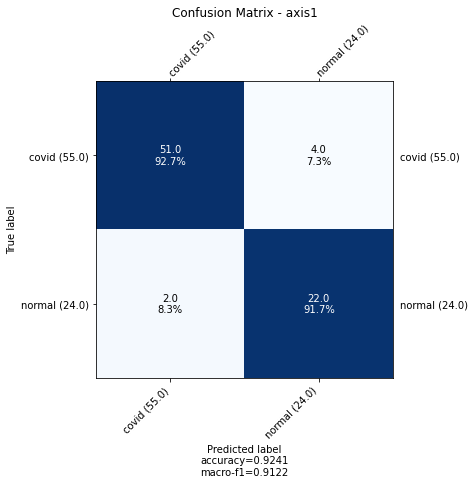

<Figure size 720x216 with 0 Axes>

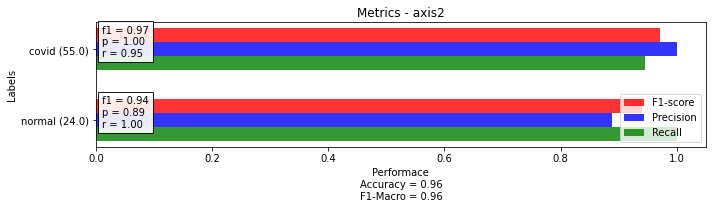

In [ ]:
'''
HMV + HCPA
'''
data_train = pd.read_csv("{}/train/train.csv".format(STRUCTURE_DATASET_FOLDER))
labels = data_train[COLUMN_TARGET].unique()

labels.sort()
labels_length = len(labels)
labels_pos_dict = dict(zip(labels, [i for i in range(labels_length)]))


for axis in SUB_FILE:
    print('\n'+axis+'\n=======================================================================================')
    
    predicted_dir = "{}/".format(OUTPUT_PREDICTED_FOLDER)
    if not os.path.exists(predicted_dir): 
        os.mkdir(predicted_dir)
    predicted_dir = "{}/{}/".format(OUTPUT_PREDICTED_FOLDER, axis)
    if not os.path.exists(predicted_dir): 
        os.mkdir(predicted_dir)
    
    
    # Predicted class for patient and fold
    df_axis = pd.DataFrame(columns=['fold', 'patient', 'real', 'predicted'])
    
    # Generate confusion matrix
    confusion_matrix = np.zeros(labels_length*labels_length).reshape(labels_length, labels_length)

    for n_fold in ['']: 
        print("\n\n\nFold", str(n_fold))        
        data_validation = pd.read_csv("{}/validation/validation.csv".format(STRUCTURE_DATASET_FOLDER))    
        
        data_validation_dict = dict(zip(data_validation['nome'], data_validation[COLUMN_TARGET]))
        
        legend_path = "{}/{}/legend".format(MODEL_FOLDER, axis)
        
        model = tf.keras.models.load_model("{}/{}/my_checkpoint".
                                           format(TRAINING_FOLDER, axis))
        
        # Test with other patients
        df = predictions_by_patient(model, data_validation['nome'].to_list(), legend_path, axis)
#         idx = df.groupby(['patient'])['count'].transform(max) == df['count']
#         df = df[idx]
        df.reset_index(drop=True, inplace=True)
        df['fold'] = n_fold
        df['real'] = ''
        last_patient = ''
        
        for index, row in df.iterrows():
            label = data_validation_dict[row['patient']]
            df.loc[index, 'real'] = label
            real_label_pos = labels_pos_dict[label]
            pred_label_pos = labels_pos_dict[row['predicted']]
            confusion_matrix[real_label_pos][pred_label_pos] += 1

        df_axis = df_axis.append(df)
        del model
        
    predicted_dir = "{}/{}/".format(OUTPUT_PREDICTED_FOLDER, axis)
    if not os.path.exists(predicted_dir): 
        os.mkdir(predicted_dir)
    df_axis.to_csv(predicted_dir+'predicted.csv', index=False)
    print(labels_pos_dict)
    print(confusion_matrix)
    
    '''
    PRINT METRICS AND CONFUSION MATRIX
    '''
    pm.plot_labels_metrics(
                cm=confusion_matrix,
                normalize=False,
                labels=labels,
                show_zero=False,
                title='Metrics - ' + axis,
                clear_diagonal=False,
                figsize=(15, 105),
                output_file="metrics.png"
            )
    pm.plot_confusion_matrix(
                cm=confusion_matrix,
                normalize=False,
                labels=labels,
                show_zero=False,
                title="Confusion Matrix - " + axis,
                clear_diagonal=False,
                output_file="matrix.png",
                figsize=(10, 7)
#                 verbose=args.verbose,
            )